# **LOS/NLOS Classifier Model**

## **Project Setup**
### **Import libraries**

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# Add the project directory to the path for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
print(f"Added project root to sys.path: {project_root}")

Added project root to sys.path: C:\Users\syahm\OneDrive\Documents\GitHub\2\UoG-DA_Test


## **Data Preparation**
### **Load and preprocess the data**

In [2]:
# Import the data preparation module
from data_preparation import preprocess

# Load and prepare the data for classification
X_train, X_test, y_train, y_test, feature_names, raw_data, processed_data = preprocess.prepare_data('classification')

# Display the shapes of the data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Feature names: {feature_names}")

Successfully imported UWB dataset module
Loading UWB dataset...
Loading files from: C:\Users\syahm\OneDrive\Documents\GitHub\2\UoG-DA_Test\data\dataset
Found 7 CSV files: ['uwb_dataset_part1.csv', 'uwb_dataset_part2.csv', 'uwb_dataset_part3.csv', 'uwb_dataset_part4.csv', 'uwb_dataset_part5.csv', 'uwb_dataset_part6.csv', 'uwb_dataset_part7.csv']
Loading: dataset/uwb_dataset_part1.csv
  Loaded 6000 samples from uwb_dataset_part1.csv
Loading: dataset/uwb_dataset_part2.csv
  Loaded 6000 samples from uwb_dataset_part2.csv
Loading: dataset/uwb_dataset_part3.csv
  Loaded 6000 samples from uwb_dataset_part3.csv
Loading: dataset/uwb_dataset_part4.csv
  Loaded 6000 samples from uwb_dataset_part4.csv
Loading: dataset/uwb_dataset_part5.csv
  Loaded 6000 samples from uwb_dataset_part5.csv
Loading: dataset/uwb_dataset_part6.csv
  Loaded 6000 samples from uwb_dataset_part6.csv
Loading: dataset/uwb_dataset_part7.csv
  Loaded 6000 samples from uwb_dataset_part7.csv
Total samples loaded: 42000
Dataset l

### **Exploratory Data Analysis**

In [3]:
# Create a DataFrame for easier exploration
df_train = pd.DataFrame(X_train, columns=feature_names)
df_train['NLOS'] = y_train

# Summary statistics
print("Summary statistics:")
df_train.describe()

Summary statistics:


,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,CH,FRAME_LEN,PREAM_LEN,BITRATE,PRFR,NLOS
count,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.0,33600.000000,33600.000000,33600.0,33600.0,33600.000000
mean,745.638869,8123.741429,11419.276190,9738.440804,72.302500,9781.042411,1316.147917,617.392649,2.0,33.798631,1043.230476,110.0,64.0,0.502024
std,4.442509,5386.707522,6230.197618,5351.050482,29.336331,4922.219814,580.673788,307.225535,0.0,5.946650,97.347186,0.0,0.0,0.500003
min,707.000000,8.000000,63.000000,413.000000,28.000000,0.000000,412.000000,133.000000,2.0,27.000000,1024.000000,110.0,64.0,0.000000
25%,744.000000,3575.750000,5317.000000,4720.750000,56.000000,6721.000000,962.000000,318.000000,2.0,27.000000,1024.000000,110.0,64.0,0.000000
50%,746.000000,7154.000000,12292.000000,10253.000000,68.000000,9953.000000,1135.000000,516.000000,2.0,39.000000,1024.000000,110.0,64.0,1.000000
75%,748.000000,12232.250000,17299.250000,14252.000000,80.000000,12428.000000,1484.000000,1024.000000,2.0,39.000000,1024.000000,110.0,64.0,1.000000
max,847.000000,20572.000000,20624.000000,20561.000000,324.000000,37208.000000,5169.000000,1056.000000,2.0,39.000000,1536.000000,110.0,64.0,1.000000


Class distribution:
NLOS
1.0    16868
0.0    16732
Name: count, dtype: int64


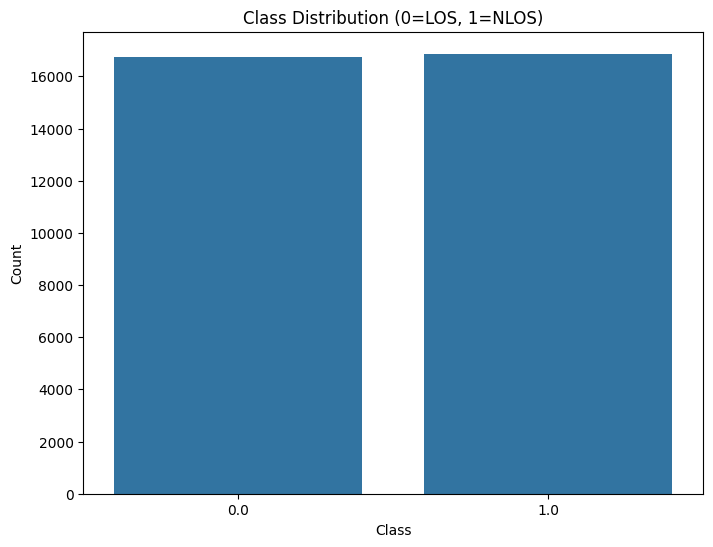

In [4]:
# Class distribution
class_distribution = df_train['NLOS'].value_counts()
print("Class distribution:")
print(class_distribution)

plt.figure(figsize=(8, 6))
sns.countplot(x='NLOS', data=df_train)
plt.title('Class Distribution (0=LOS, 1=NLOS)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

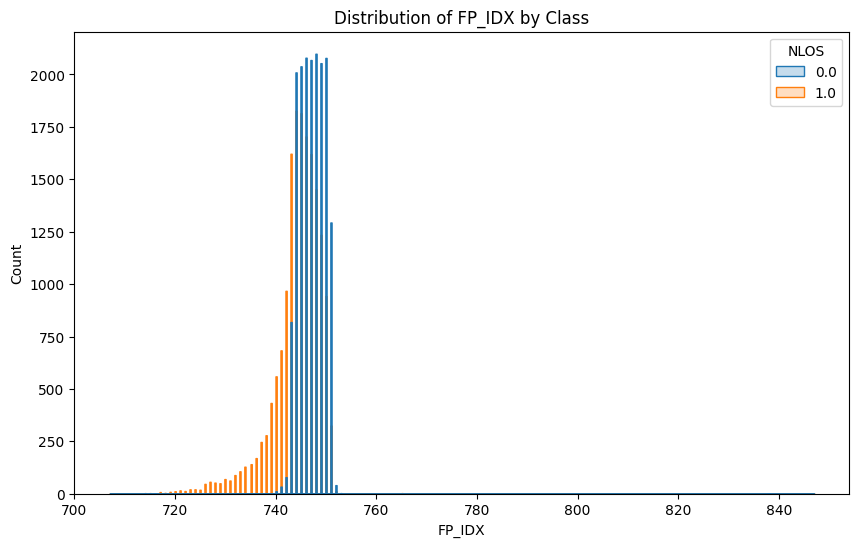

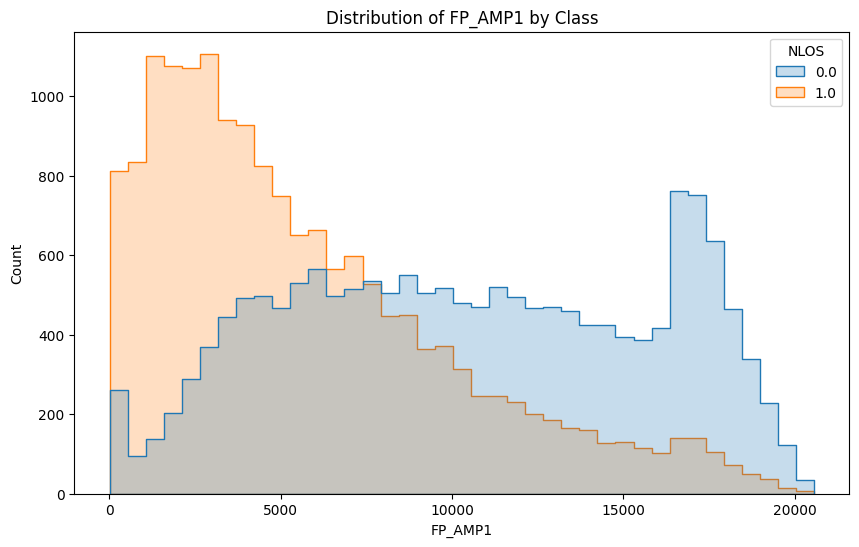

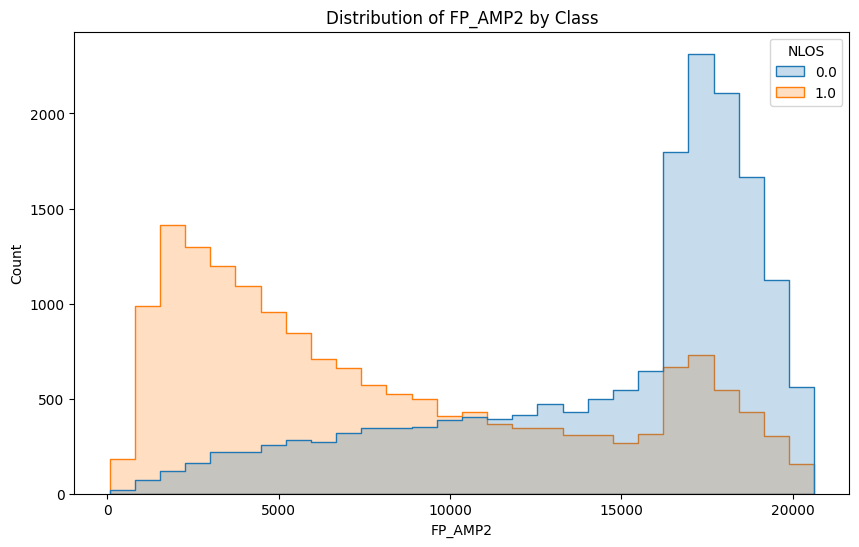

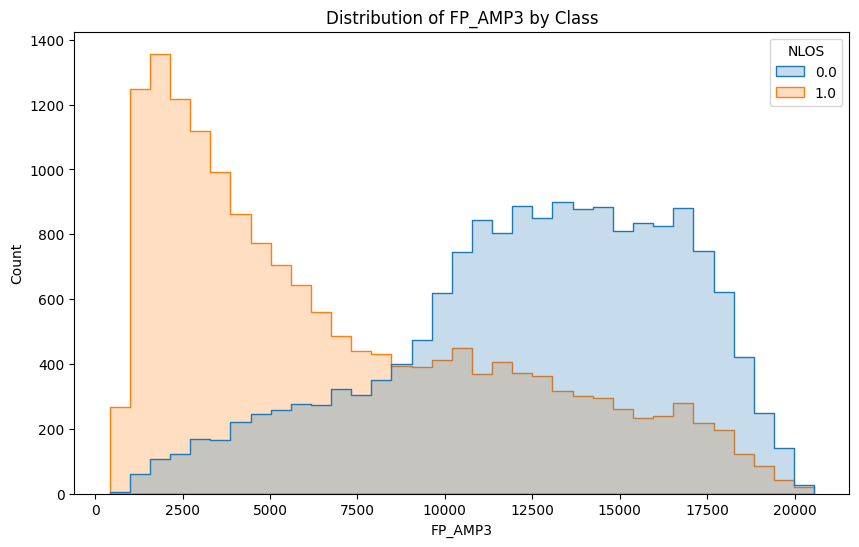

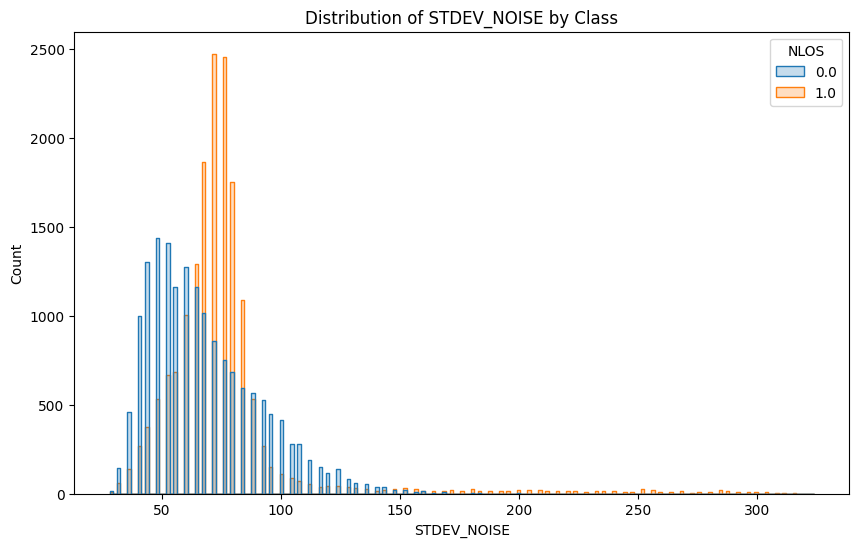

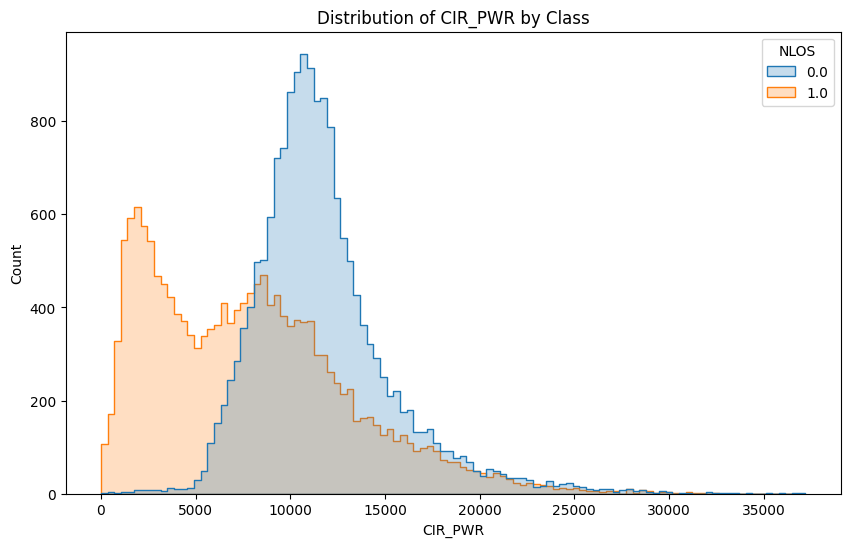

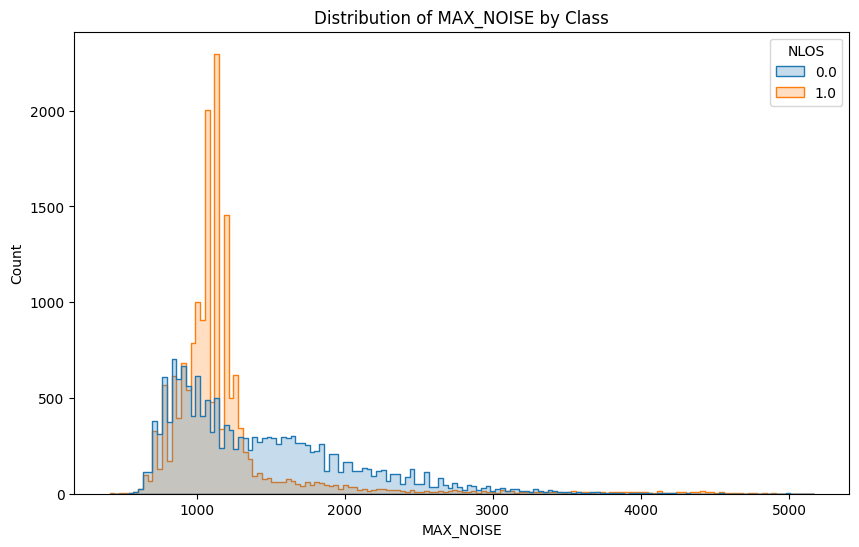

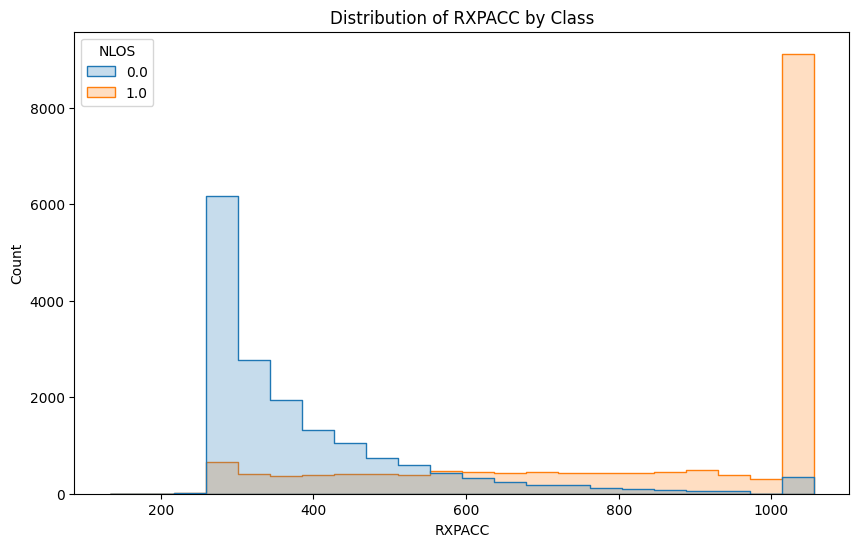

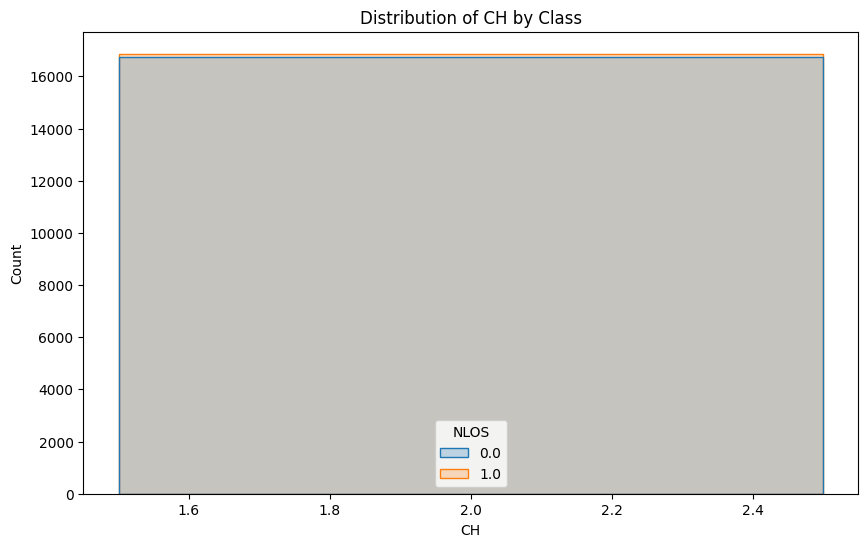

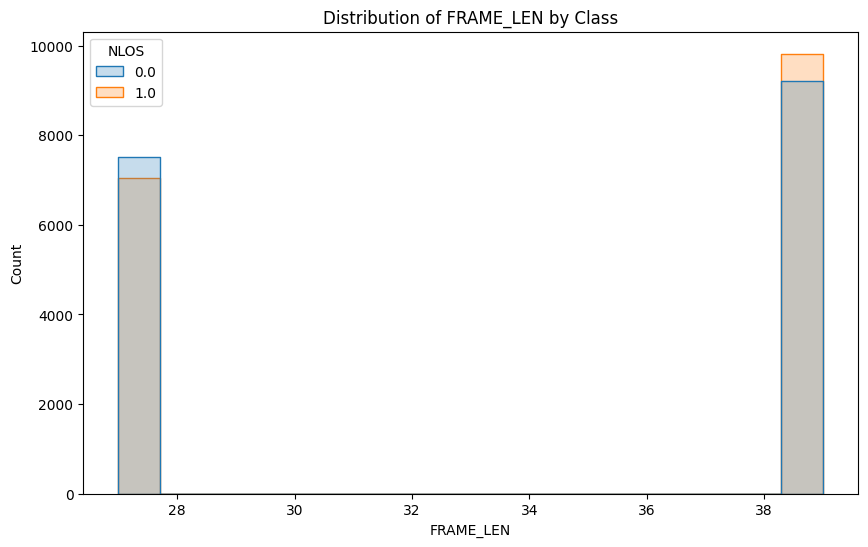

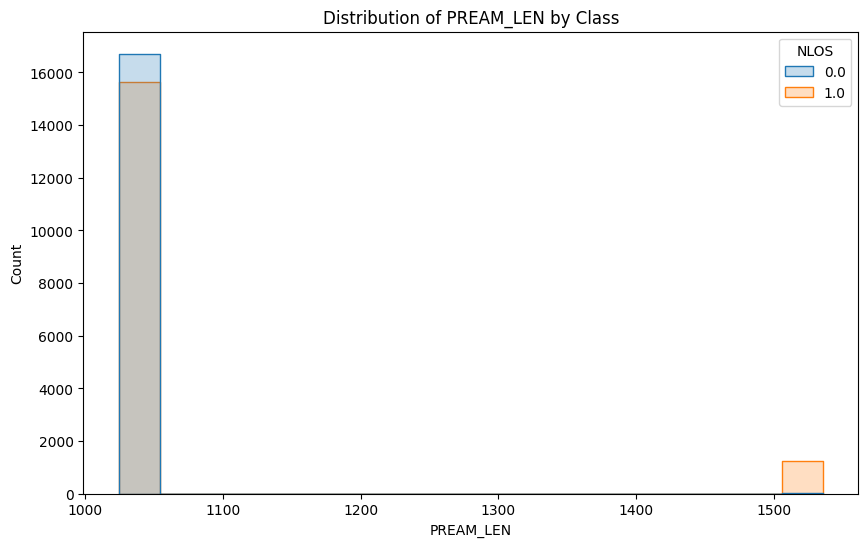

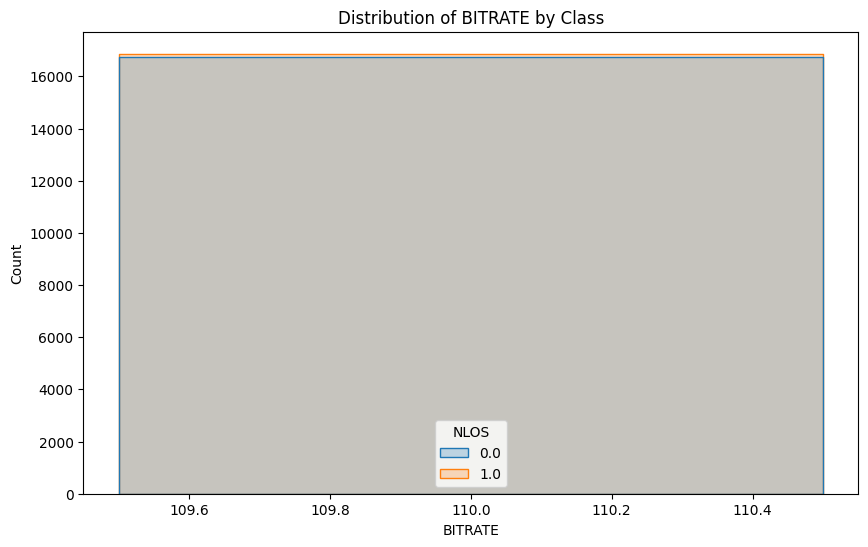

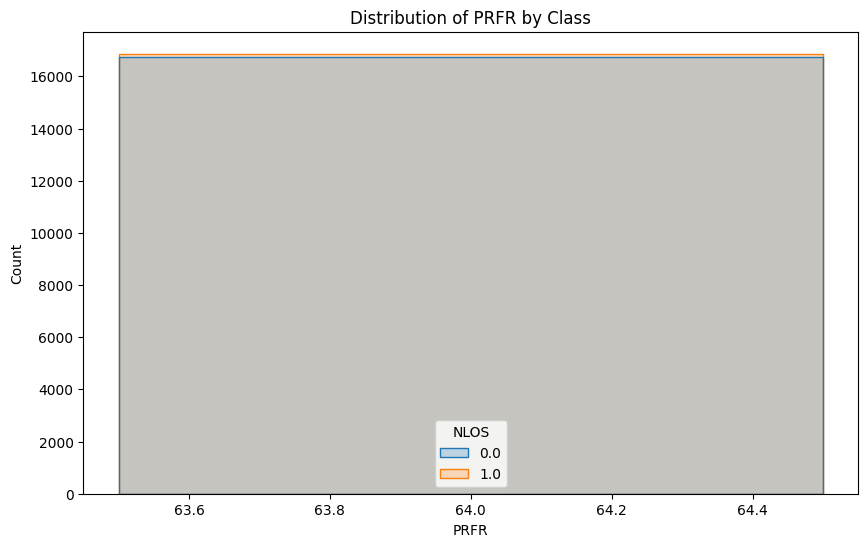

In [5]:
# Feature distributions by class - WITHOUT KDE to avoid errors
for feature in feature_names:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_train, x=feature, hue='NLOS', kde=False, element='step')
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

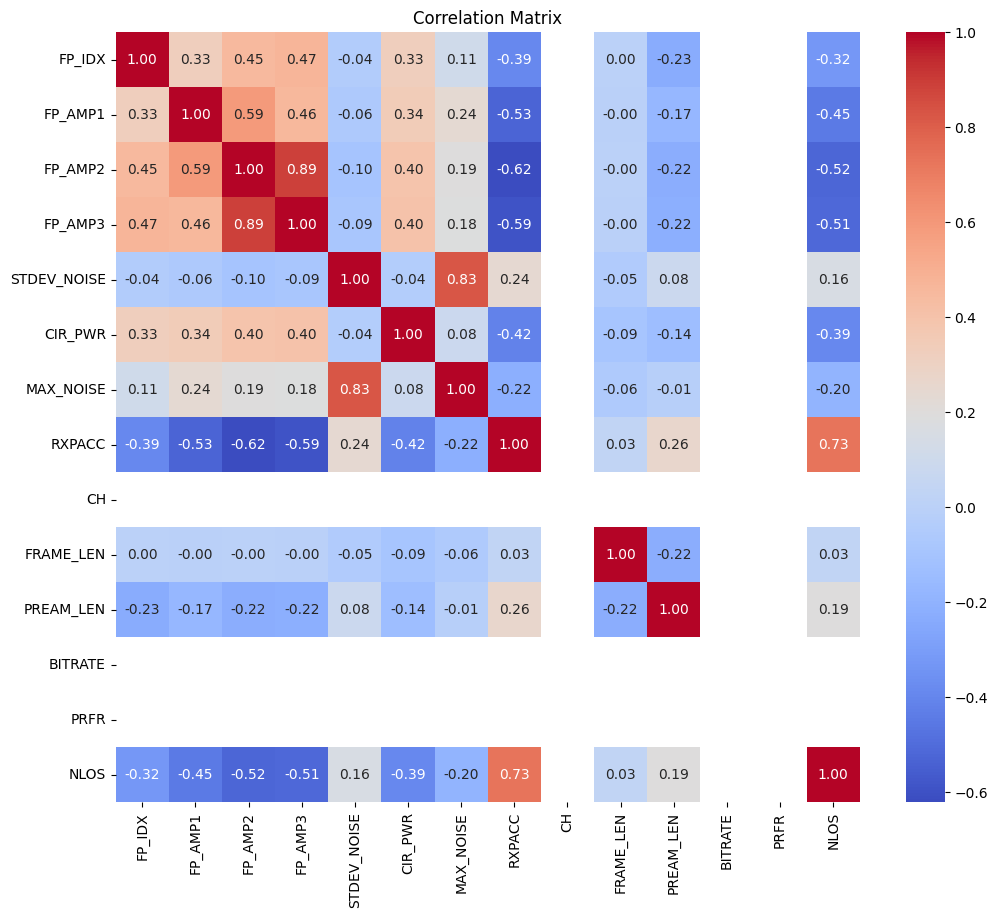

In [6]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## **Model Training and Evaluation**
### **Train various classification models**

In [7]:
# Define the classification models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(probability=True, random_state=42)
}

# Standardize the features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store the results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    
    # Train the model (use scaled data for some models)
    if name in ['Logistic Regression', 'KNN', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # ROC curve and AUC
    if hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, roc_auc = None, None, None
    
    # Feature importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importance = model.coef_[0]
    else:
        feature_importance = None
    
    # Store the results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'feature_importance': feature_importance
    }
    
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Training Logistic Regression...
  Accuracy: 0.8532, Precision: 0.8891, Recall: 0.8015, F1: 0.8431
Training Random Forest...
  Accuracy: 0.8701, Precision: 0.8961, Recall: 0.8325, F1: 0.8631
Training Gradient Boosting...
  Accuracy: 0.8696, Precision: 0.9018, Recall: 0.8248, F1: 0.8616
Training KNN...
  Accuracy: 0.8539, Precision: 0.8706, Recall: 0.8258, F1: 0.8476
Training SVM...
  Accuracy: 0.8718, Precision: 0.9112, Recall: 0.8192, F1: 0.8628


### **Visualize model performance**

<Figure size 1200x800 with 0 Axes>

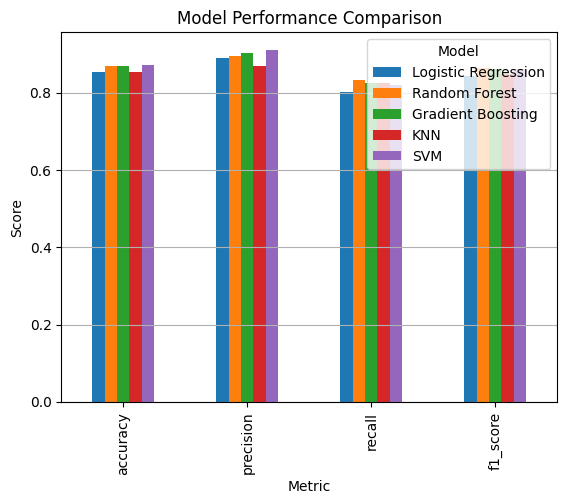

In [8]:
# Performance comparison
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
comparison_df = pd.DataFrame({name: [results[name][metric] for metric in metrics] for name in results.keys()}, 
                             index=metrics)

plt.figure(figsize=(12, 8))
comparison_df.plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.grid(axis='y')
plt.show()

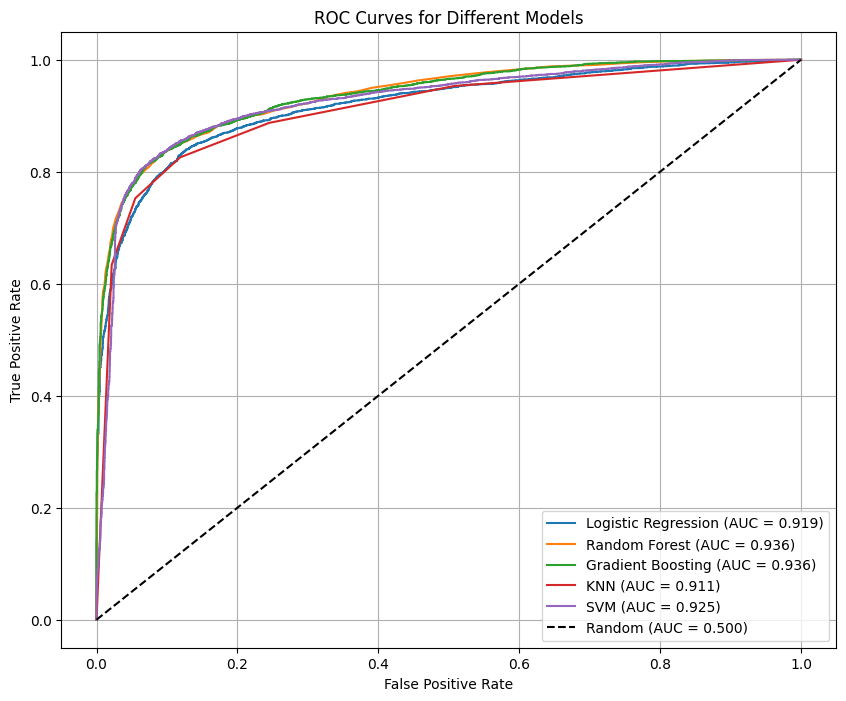

In [9]:
# ROC curves
plt.figure(figsize=(10, 8))
for name in results:
    if results[name]['fpr'] is not None and results[name]['tpr'] is not None:
        plt.plot(results[name]['fpr'], results[name]['tpr'], 
                 label=f'{name} (AUC = {results[name]["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.grid(True)
plt.show()

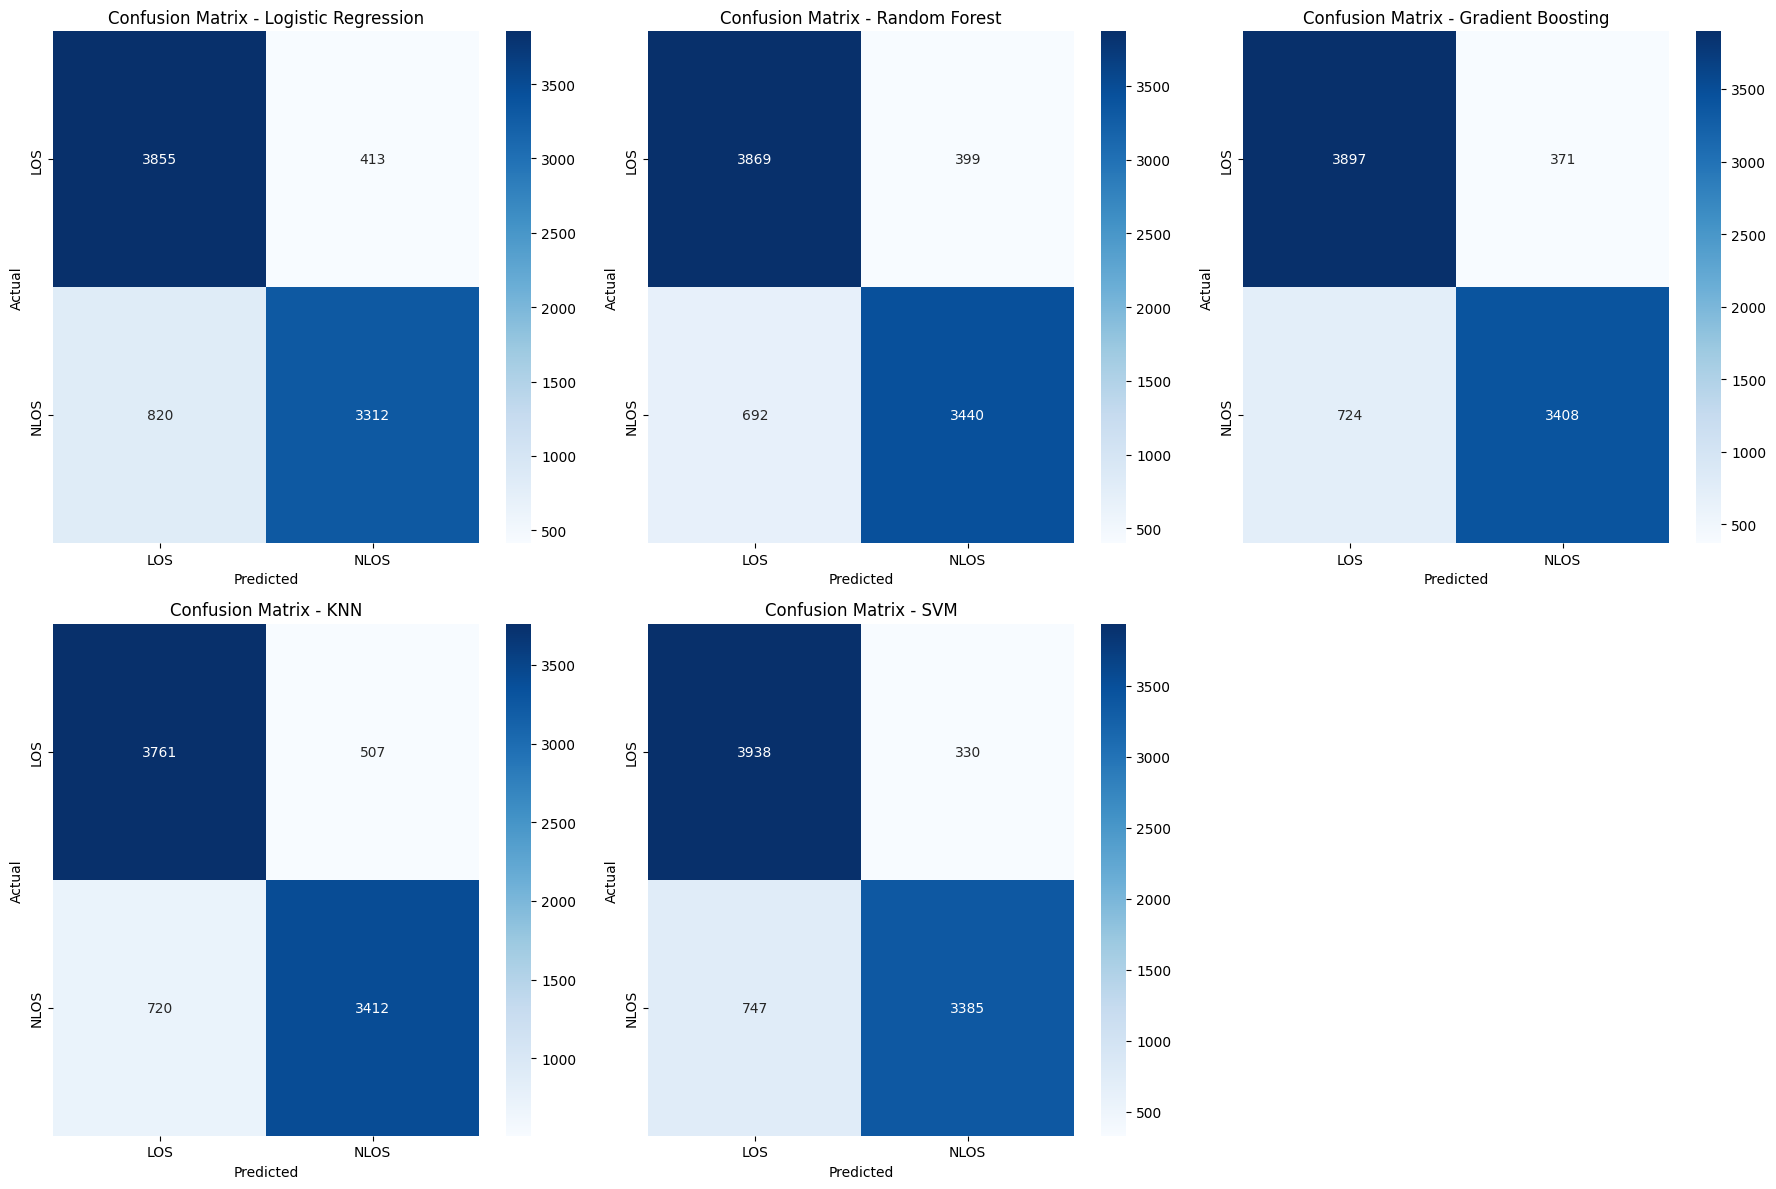

In [10]:
# Confusion matrices for all models
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, name in enumerate(results):
    if i < len(axes):
        sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_xticklabels(['LOS', 'NLOS'])
        axes[i].set_yticklabels(['LOS', 'NLOS'])

# Remove any unused axes
for i in range(len(results), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### **Feature importance analysis**

Best performing model based on F1 score: Random Forest


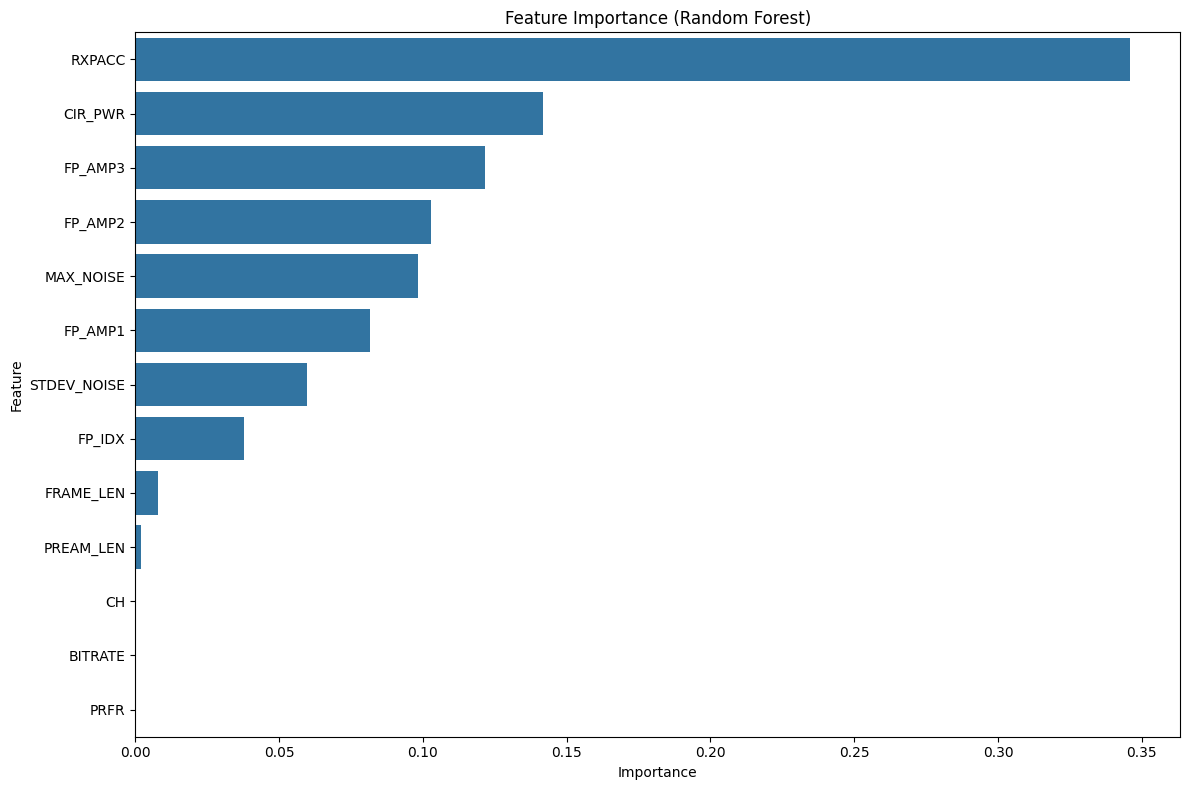

In [11]:
# Feature importance for best performing model (assuming Random Forest)
best_model_name = max(results, key=lambda x: results[x]['f1_score'])
print(f"Best performing model based on F1 score: {best_model_name}")

if results[best_model_name]['feature_importance'] is not None:
    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': results[best_model_name]['feature_importance']
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importance ({best_model_name})')
    plt.tight_layout()
    plt.show()

## **Conclusion and Recommendations**

In [12]:
# Determine the best model
best_model_accuracy = max(results, key=lambda x: results[x]['accuracy'])
best_model_f1 = max(results, key=lambda x: results[x]['f1_score'])

print(f"Best model by accuracy: {best_model_accuracy} ({results[best_model_accuracy]['accuracy']:.4f})")
print(f"Best model by F1 score: {best_model_f1} ({results[best_model_f1]['f1_score']:.4f})")

# Recommendations based on the analysis
print("\nRecommendations:")
print(f"1. Use {best_model_f1} for LOS/NLOS classification due to its balanced performance.")
print("2. Important features for classification (from most to least important):")
if results[best_model_f1]['feature_importance'] is not None:
    for feature, importance in importance_df.head(5).values:
        print(f"   - {feature}: {importance:.4f}")
print("3. Focus on these features when optimizing the classification model.")

Best model by accuracy: SVM (0.8718)
Best model by F1 score: Random Forest (0.8631)

Recommendations:
1. Use Random Forest for LOS/NLOS classification due to its balanced performance.
2. Important features for classification (from most to least important):
   - RXPACC: 0.3460
   - CIR_PWR: 0.1418
   - FP_AMP3: 0.1216
   - FP_AMP2: 0.1029
   - MAX_NOISE: 0.0983
3. Focus on these features when optimizing the classification model.
